This code is to combine multiple individual components learnt regarding MLPs.
The individual components are in the folder: indv_algos/

In this code, we will train an MLP to classify images from the MNIST handwritten digits database.
Here, we will visualize the dataset, define the network, train the model and evaluate the performance. 


In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# check if cuda exists
print(torch.cuda.is_available())

True


In [3]:
# Load data

# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [14]:
import torch.utils
import torch.utils.data


train_data = datasets.MNIST(root="~/datasets/MNIST_data/", download=True, train=True, transform=transform)
test_data = datasets.MNIST(root="~/datasets/MNIST_data/", download=True, train=False, transform=transform)

# number of subprocesses to load the data
num_workers =  4

# samples per batch
batch_size = 64

# percentage of training set to be made as validation set
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size*num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# sampler for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# dataloaders 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

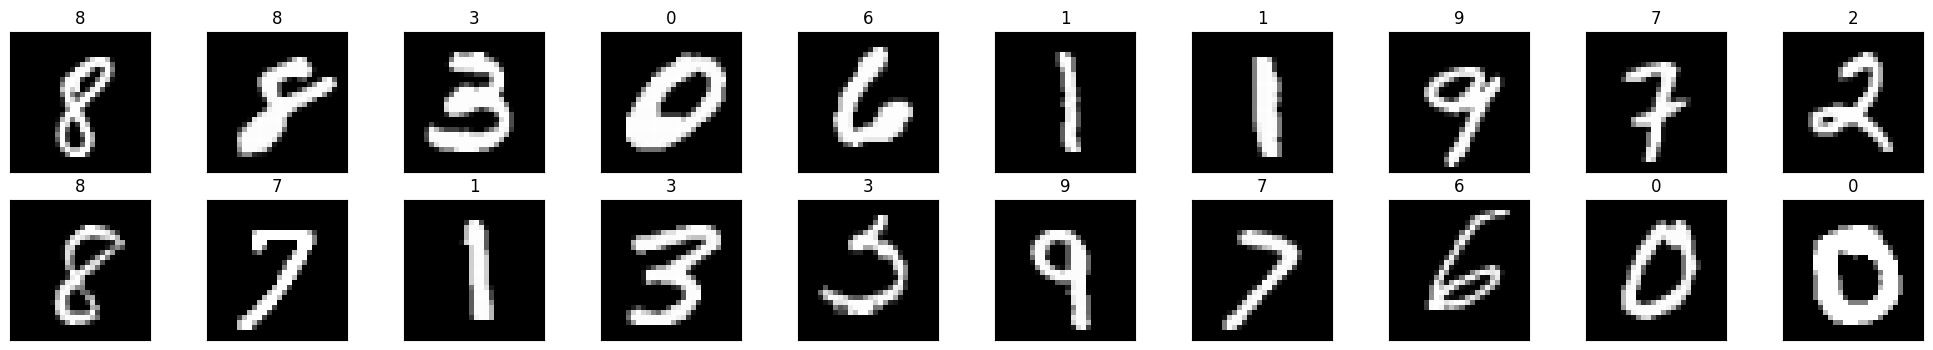

In [7]:
# Visualize the train data
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)

images, labels = next(dataiter)
images = images.numpy()

# plot with the correspondign labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))



In [8]:
# Network architecture

import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        # flatten the image
        x = x.view(-1, 28*28)

        # hidden layers with relu activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = self.fc4(x)


        return x
    

model = Net()

print(model)




Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Using device: cuda


In [11]:
# training


n_epochs = 50

# min valid loss
valid_loss_min = np.Inf

train_losses = []
valid_losses = []

for epoch in range(n_epochs):

    train_loss = 0.0
    valid_loss = 0.0

    # train
    model.train()


    for data, target in train_loader:

        data, target = data.to(device), target.to(device)

        # clear gradient
        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # loss
        loss = criterion(output, target)

        # backward pass
        loss.backward()

        # single optimization step
        optimizer.step()

        # update running loss
        train_loss += loss.item()

    
    # validation

    model.eval()

    for data, target in valid_loader:

        data, target = data.to(device), target.to(device)

        output = model(data)

        # loss
        loss = criterion(output, target)

        valid_loss += loss.item()

    
    # training and validation statistics

    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './model.pt')
        valid_loss_min = valid_loss




Epoch: 1 	Training Loss: 1.737589 	Validation Loss: 0.788896
Validation loss decreased (inf --> 0.788896).  Saving model ...
Epoch: 2 	Training Loss: 0.664303 	Validation Loss: 0.428368
Validation loss decreased (0.788896 --> 0.428368).  Saving model ...
Epoch: 3 	Training Loss: 0.464742 	Validation Loss: 0.350544
Validation loss decreased (0.428368 --> 0.350544).  Saving model ...
Epoch: 4 	Training Loss: 0.393534 	Validation Loss: 0.304918
Validation loss decreased (0.350544 --> 0.304918).  Saving model ...
Epoch: 5 	Training Loss: 0.342336 	Validation Loss: 0.267894
Validation loss decreased (0.304918 --> 0.267894).  Saving model ...
Epoch: 6 	Training Loss: 0.301177 	Validation Loss: 0.239472
Validation loss decreased (0.267894 --> 0.239472).  Saving model ...
Epoch: 7 	Training Loss: 0.268815 	Validation Loss: 0.219771
Validation loss decreased (0.239472 --> 0.219771).  Saving model ...
Epoch: 8 	Training Loss: 0.246858 	Validation Loss: 0.202765
Validation loss decreased (0.21977

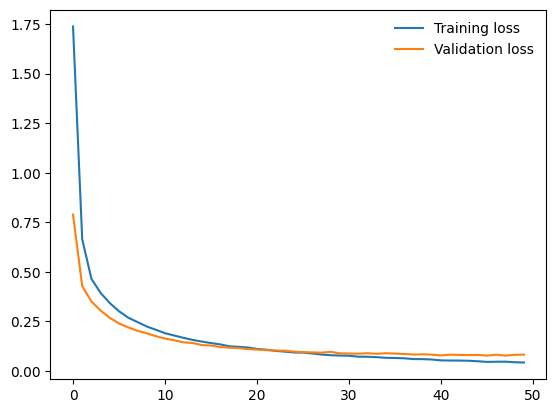

In [12]:
# plot the train and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [13]:
# Load the model with the lowest validation loss

model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [17]:
# Test the trained network

test_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()

for data, target in test_loader:

    data, target = data.to(device), target.to(device)

    # forward pass
    output = model(data)

    # calucalyte the loss
    loss = criterion(output, target)

    # update test loss
    test_loss += loss.item() * data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

    

Test Loss: 0.066726

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 97% (987/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9805/10000)


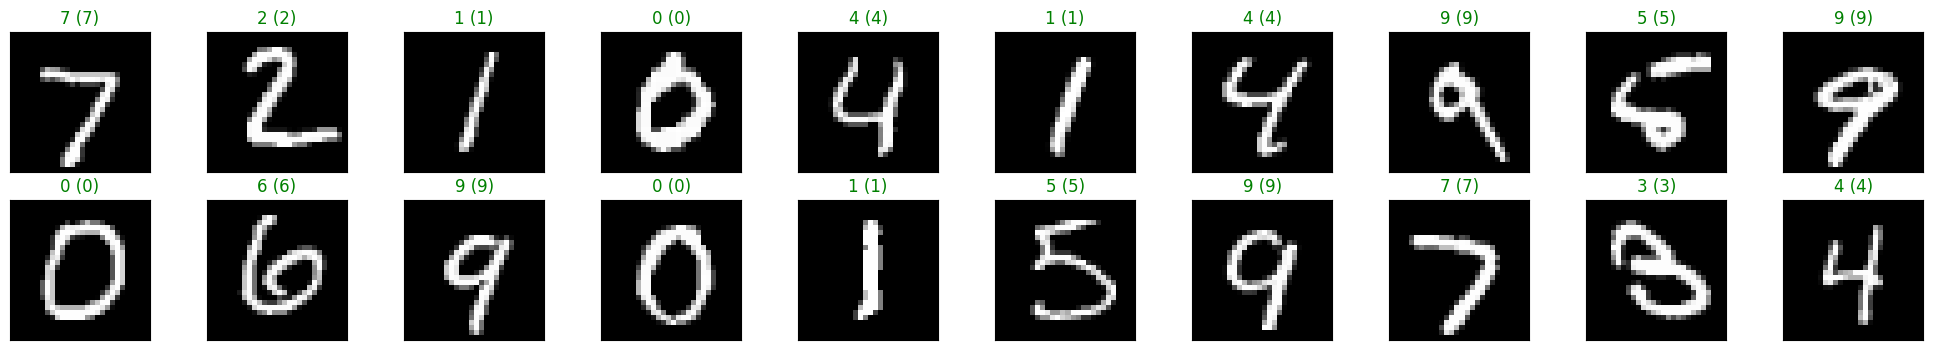

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

model = model.to('cpu')

# forward pass
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))